In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format

# Diabetes Dataset

### About Dataset
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes.

### Content
Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

- *Pregnancies:* Number of times pregnant
- *Glucose:* Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- *BloodPressure:* Diastolic blood pressure (mm Hg)
- *SkinThickness:* Triceps skin fold thickness (mm)
- *Insulin:* 2-Hour serum insulin (mu U/ml)
- *BMI:* Body mass index (weight in kg/(height in m)^2)
- *DiabetesPedigreeFunction:* Diabetes pedigree function
- *Age:* Age (years)
- *Outcome:* Class variable (0 or 1)

In [21]:
#Importar dataset
df_diabetes = pd.read_csv("C:/Users/THINKBOOK/Documents/1. ESTUDIOS y FORMACIONES/PROGRAMMING/Data Science/Desarrollos de las clases/Clase 18 - Aprendizaje Supervisado - Clasificación (parte 2)/diabetes.csv")
df_diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.60,0.63,50,1
1,1,85,66,29,0,26.60,0.35,31,0
2,8,183,64,0,0,23.30,0.67,32,1
3,1,89,66,23,94,28.10,0.17,21,0
4,0,137,40,35,168,43.10,2.29,33,1


## EDA (Exploratory Data Analysis)

In [22]:
#Explorar la dimensionalidad del dataset
print(f"Shape del dataset de entrenamiento: {df_diabetes.shape}")

Shape del dataset de entrenamiento: (768, 9)


In [23]:
#Explorar la estrucutra del dataset
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


se observa que todas las columnas del dataset son númericas, no se evidencian además valores nulos.

In [24]:
#Verificar existencia de valores nulos
df_diabetes.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

### Explorando columnas númericas

In [25]:
#Verificando columnas numericas
df_diabetes.select_dtypes(include=[np.number]).columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

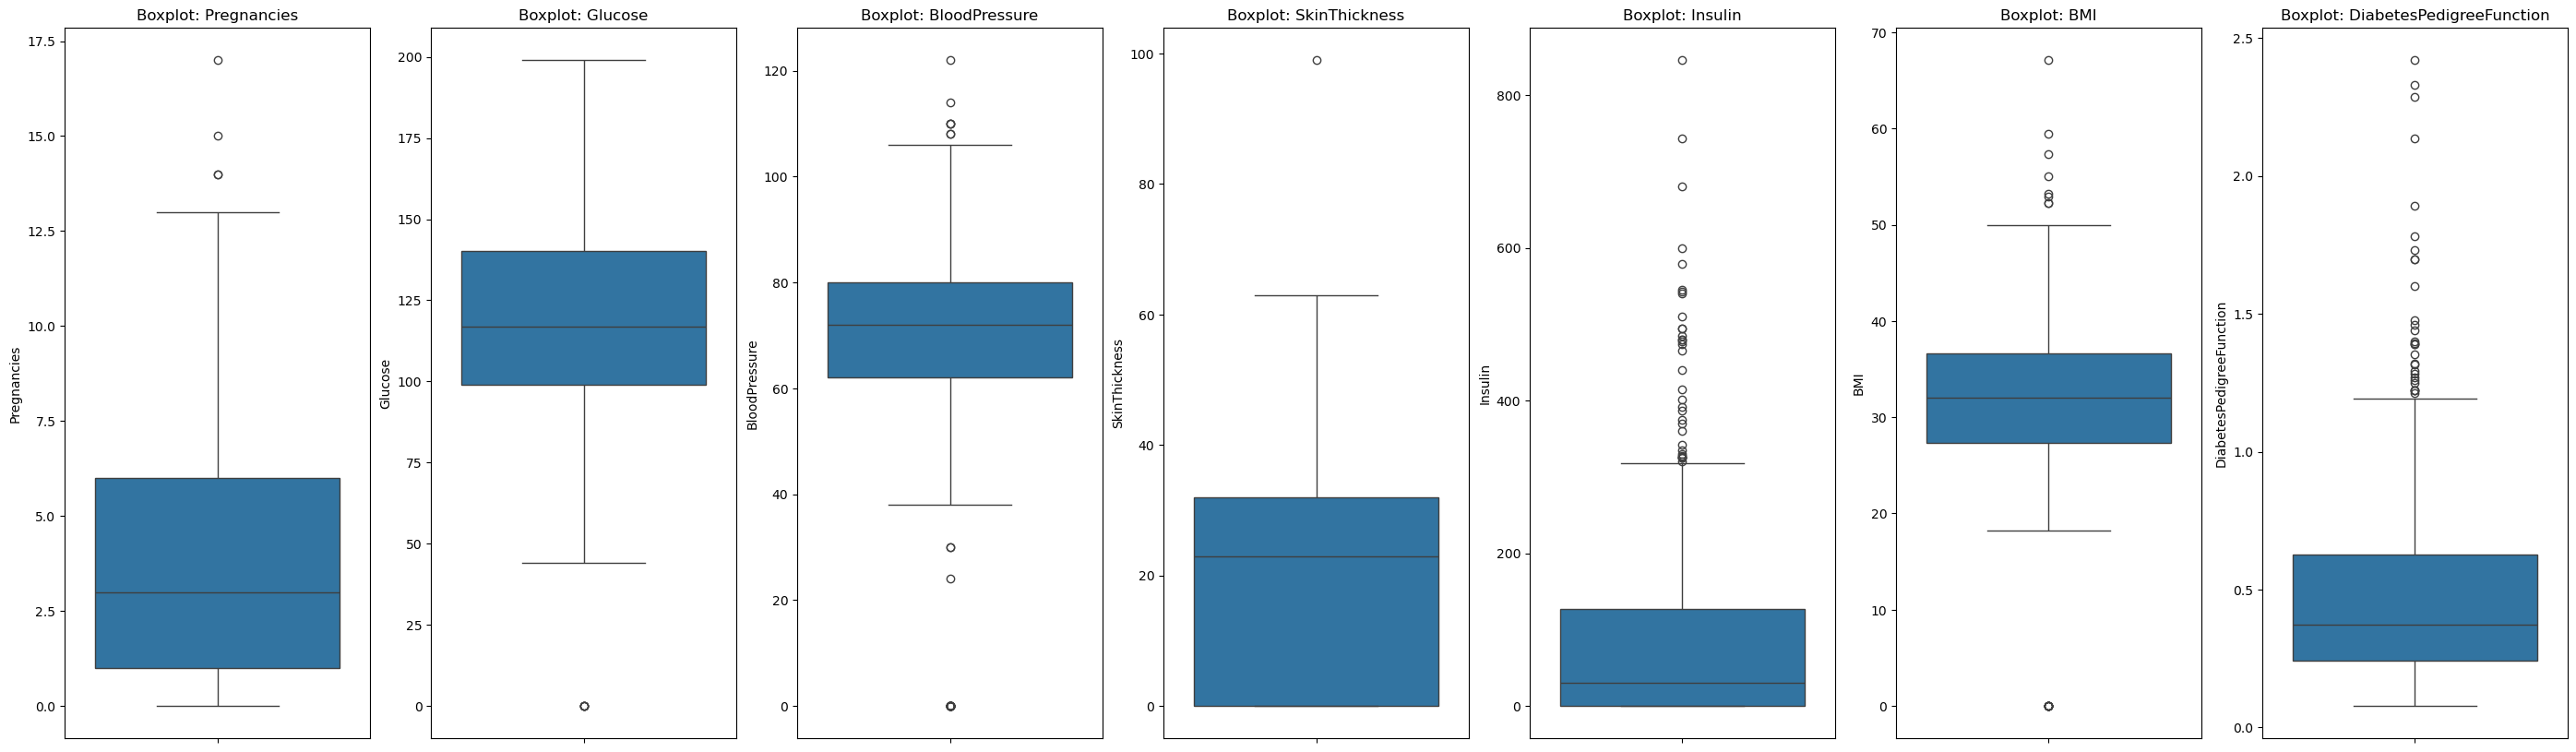

In [26]:
#Boxplot para explorar variables numericas del dataset
numeric_columns= df_diabetes.select_dtypes(include=[np.number]).columns
fig, axs = plt.subplots(1, 7, figsize = (35,10))

for i, ax in enumerate(axs.flatten()):
    if i < len(numeric_columns):
        ax.set_title("Boxplot: " + f'{numeric_columns[i]}')
        sns.boxplot(df_diabetes[numeric_columns[i]], ax=ax)
    else:
        ax.set_visible(False)

plt.show()

### Análsis de outliers que deben ser eliminados y conservados

A partir del boxplot de todas las variables numericas del dataset, observamos que todas presentan outliers, analizaremos caso por caso cuáles conservar y cuáles eliminar, para ello tendremos en cuenta las métricas de evaluación y el objetivo de que el modelo generado sea aplicable a tanto a una población promedio como a una población con alguna condición como la obesidad por ejemplo.

*Pregnancies*

Se identifican outliers en rangos altos (más de 13 embarazos). Estos casos aunque pueden ser posibles resultan altamente inusuales, teniendo en cuenta por ejemplo que en el 2023 el promedio de embarazos por mujer fue de 2,3 hijos (promedio global). Por tanto procedemos a eliminar todos los outliers presentes en esta variable.

*Glucose*

Se identifican outliers en rangos bajos (glucosa de 0). Puede deberse a un error en medición, por tanto eliminamos este outlier.

*BloodPressure*

Se identifican outliers en rangos bajos (presiones arteriales menores a 40 mm Hg) y en rangos altos (presiones arteriales mayores a ≈ 110), según la literatura: ds

**Rango normal para adultos:** 
- *Ideal:* Menos de 120/80 mmHg.

Valores a considerar: 
**Presión arterial elevada:** 120-129/80 mmHg.
**Hipertensión:** 130/80 mmHg o más.

A partir de lo anterior procederemos a conservar los outliers que se encuentran en rangos altos, dado que representan a personas con condiciones médicas como la hipertensión, es decir, no son valores absurdos y que a su vez nos pueden brindar información útil en el aprendizaje del modelo en la diabetes. Por el contrario personas con valores de presión arterial menores a 40 mmHg resultan ser casos improbables. Una presión normal se considera inferior a 120/80 mm Hg y la presión baja es cuando es inferior a 90/60 mm Hg. Una lectura tan baja podría indicar una situación de emergencia médica (como un shock), donde los órganos vitales no reciben suficiente sangre, y requiere atención médica inmediata. Por tanto desestimaremos esos casos.

*SkinThickness (grosor de la piel)*

Se identifican outliers en rangos altos (grosores de piel > 60 mm) y a su vez valores muy altos fuera de lo común (grosores de piel > 40 mm). Según la literatura la cantidad de grasa subcutánea para el pliegue del tríceps:

- **Valores bajos (<5 mm en hombres, <8 mm en mujeres)**: suelen indicar **baja reserva grasa** y en algunos casos **riesgo de desnutrición.**
- **Valores dentro del rango (6–13 mm hombres, 10–20 mm mujeres):** considerados normales.
- **Valores altos (20–22 mm en hombres, 30–35 mm en mujeres):** representan un extremo **alto pero todavía normal**, común en personas con mayor porcentaje de grasa corporal, especialmente mujeres en edad fértil.

A partir de lo anterior y teniendo en cuenta que nuestro dataset cuenta con pocos registros tomaremos la decisión de desestimar solamente los casos por encima de los 60 mm. Valores como 60 mm resultan ser casos fuera de lo normal o atipicos presentados por personas con obesidad, sin embargo esta información podría ser útil para nuestro modelo.

*Insulin*

Se identifican outliers en rangos altos (valores de insulina mayores a ≈ 230). Según la literatura: 

- **Normal en ayunas:** 2–25 μU/mL (ideal <10).
- **Posprandial (después de comer):** puede subir a 40–60 μU/mL.
- **Valores muy altos en ayunas (>25)** → sospecha de resistencia a la insulina.
- **Valores muy bajos (<2)** → sospecha de déficit de producción de insulina.

En casos de resistencia a la insulina severa (obesidad marcada, síndrome metabólico, diabetes tipo 2 avanzada), pueden encontrarse niveles altos, pero rara vez pasan de **100–150 μU/mL.** Valores de **>200 μU/mL** son considerados **anormales y patológicos.**

A partir de lo anterior y considerando que nuestro dataset contiene pocos registros, tomaremos la decisión de eliminar solamente registros por encima de 230.
 
*BMI* 

Se identifican outliers en rangos bajos (BMI en 0) y en rangos altos (BMI mayores a 50). Según la literatura: 

**Rangos normales de IMC en adultos (OMS)**

- < 18.5 → Bajo peso
- 18.5 – 24.9 → Normopeso (peso saludable)
- 25 – 29.9 → Sobrepeso
- 30 – 34.9 → Obesidad grado I
- 35 – 39.9 → Obesidad grado II
- ≥ 40 → Obesidad grado III (mórbida o severa)

Valores por encima de 50 corresponden a personas con obesidad III. Tomaremos la decisión de trabajar con estos registros.

*DiabetesPedigreeFunction (índice que cuantifica la probabilidad de tener diabetes basándose en la historia familiar)*

Se identifican outliers en rangos altos (mayores a 1.2). Según la literatura: 

- **Valores bajos (<0.5):** bajo riesgo genético.
- **Valores altos (>1.0):** riesgo genético elevado.

Los valores suelen ir de 0.1 a 2.5 aprox, por tanto los outliers presentes suelen ser valores aceptables.


## Preprocesamiento de datos

### Eliminar outliers

In [27]:
# 1) Partimos del original
df = df_diabetes.copy()

# 2) Definimos la máscara de outliers (todo lo que se quiere ELIMINAR)
mask_outliers = (
    (df ['Pregnancies'] > 13) |
    (df ['Glucose'] == 0) |
    (df ['BloodPressure'] < 40) |
    (df ['SkinThickness'] > 60) |
    (df ['Insulin'] > 230)
)

# 3) Nos quedamos con lo que NO es outlier
df_diabetes_clean = df.loc[~mask_outliers].copy()

#Verificación rápida (para asegurar que sí se eliminaron)
assert (df_diabetes_clean['Pregnancies'] <= 13).all()
assert (df_diabetes_clean['Glucose'] != 0).all()
assert (df_diabetes_clean['BloodPressure'] >= 40).all()
assert (df_diabetes_clean['SkinThickness'] <= 60).all()
assert (df_diabetes_clean['Insulin'] <= 230).all()

*mask_outliers*

Es un vector de valores booleanos (True/False) del mismo tamaño que el DataFrame.
- *True* → esa fila es **outlier** (la quieres eliminar).
- *False* → esa fila es **válida** (la quieres conservar).

*~mask_outliers*
- El símbolo **~** invierte el booleano:
    - True → False
    - False → True

Entonces, **~mask_outliers** marca **las filas que NO son outliers.**

*Uso de assert*
- Si la condición es **True, no devuelve nada** → simplemente continúa la ejecución normal del programa.
- Si la condición es **False, lanza un error** *AssertionError* y el programa se detiene.

In [28]:
print(f"Shape del dataset antes de eliminar outliers: {df_diabetes.shape}")
print(f"Shape del dataset después de eliminar outliers: {df_diabetes_clean.shape}")

Shape del dataset antes de eliminar outliers: (768, 9)
Shape del dataset después de eliminar outliers: (653, 9)


### Estandarización de los datos

In [29]:
scaler = StandardScaler()
df_diabetes_escalado = scaler.fit_transform(df_diabetes_clean.drop('Outcome', axis = 1))

#Llevar a DataFrame 'df_diabetes_escalado'
pd.DataFrame(df_diabetes_escalado, columns = df_diabetes_clean.drop('Outcome', axis = 1).columns)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.67,1.02,-0.05,0.97,-0.82,0.25,0.52,1.42
1,-0.86,-1.16,-0.55,0.58,-0.82,-0.74,-0.36,-0.19
2,1.28,2.23,-0.72,-1.30,-0.82,-1.20,0.67,-0.11
3,-0.86,-1.02,-0.55,0.19,0.56,-0.53,-0.94,-1.05
4,-1.17,0.64,-2.73,0.97,1.64,1.59,5.81,-0.02
...,...,...,...,...,...,...,...,...
648,1.90,-0.60,0.29,1.81,1.82,0.15,-0.93,2.53
649,-0.56,0.12,-0.22,0.45,-0.82,0.70,-0.39,-0.53
650,0.36,0.09,-0.05,0.19,0.82,-0.79,-0.69,-0.28
651,-0.86,0.26,-1.05,-1.30,-0.82,-0.24,-0.36,1.17


## Balanceo de datos
Podemos aplicar:

- *Oversampling*
- *Undersampling*

<Axes: xlabel='Outcome', ylabel='count'>

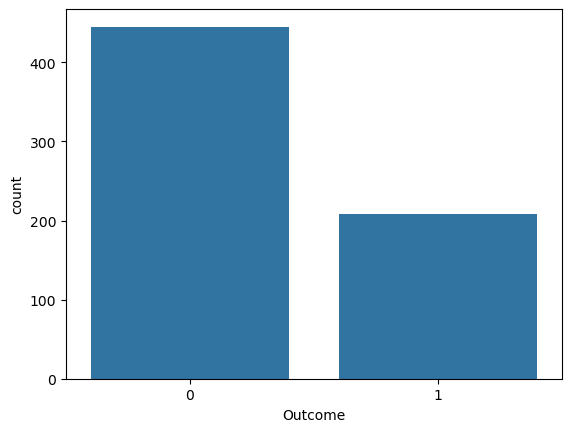

In [30]:
#Conteo de datos por status
sns.countplot(x = 'Outcome', data = df_diabetes_clean)

A partir del conteo identificamos que tenemos más datos para el status 0 (personas sin diabetes) que para el status 1(personas con diabetes), por lo que es posible realizar cualquiera de los dos operaciones:

- *Undersampling para los datos del status 0:* Toma aleatoriamente datos de este status para igual en cantidad al status que menos tiene.
- *Oversampling para los datos del status 1:* Toma muestras aleatorias de este status, las duplica o triplica hasta igual en cantidad de datos al status que mas tiene.

*Definición de las caracteristicas y columna objetivo*

In [31]:
X = df_diabetes_escalado         # Caracteristicas
y = df_diabetes_clean['Outcome'] # Columna objetivo

In [48]:
from imblearn.over_sampling import RandomOverSampler 

#Método RandomOverSampler: replica datos existentes aleatoriamente
ros = RandomOverSampler(random_state = 42)
X_resampled, y_resampled = ros.fit_resample(X, y)

#Visualizar balanceo de datos
print(f"Shape of balanced X: {X_resampled.shape}")
print(f"Shape of balanced y: {y_resampled.shape}")
print(f"Value counts for y:{y_resampled.value_counts()}")

Shape of balanced X: (890, 8)
Shape of balanced y: (890,)
Value counts for y:Outcome
1    445
0    445
Name: count, dtype: int64


## Entrenamiento y Evaluación

#### 1. Separación de los datos en entrenamiento y prueba

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 42, stratify = y_resampled)

#### 2. Selección de los modelos a usar

In [34]:
# Instanciar los modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier #Modelo basado en arboles que usa bagging o votacion
from sklearn.ensemble import GradientBoostingClassifier #Modelo basado en arboles que usa bagging o votacion
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier #Modelo basado en arboles que usa bagging o votacion

model_DT  = DecisionTreeClassifier()
model_Bagging = BaggingClassifier()
model_RF  = RandomForestClassifier() #modelo mas agil y eficiente
model_AB  = AdaBoostClassifier()
model_SVC = SVC() #modelo menos agil y menos eficiente para estos casos
model_ET  = ExtraTreesClassifier()
model_XGB = XGBClassifier() #modelo mas agil y eficiente
model_Logistic = LogisticRegression() #modelo menos agil y menos eficiente para estos casos
model_GB  = GradientBoostingClassifier()

#### 3. Entrenar los modelos (FIT)

In [35]:
#Aprendizaje de los modelos con base a la data alimentada
model_DT.fit(X_train,y_train)
model_Bagging.fit(X_train,y_train)
model_RF.fit(X_train,y_train)
model_AB.fit(X_train,y_train)

model_ET.fit(X_train,y_train)
model_XGB.fit(X_train,y_train)
model_Logistic.fit(X_train,y_train)
model_GB.fit(X_train,y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [36]:
model_SVC.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


#### 4. Realizar la predicción con los modelos entrenados previamente (PREDICT)

In [37]:
#Predecir con base a datos diferentes con los que fue aliemntado
#Predecir y obtener el accuracy
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
y_pred_DT = model_DT.predict(X_test)
y_pred_Bagging = model_Bagging.predict(X_test)
y_pred_RF = model_RF.predict(X_test)
y_pred_AB = model_AB.predict(X_test)
y_pred_SVC = model_SVC.predict(X_test)
y_pred_ET = model_ET.predict(X_test)
y_pred_XGB = model_XGB.predict(X_test)
y_pred_Logistic = model_Logistic.predict(X_test)
y_pred_GB = model_GB.predict(X_test)

models = ['DT', 'Bagging', 'RF', 'AB', 'ET', 'XGB', 'Logistic', 'GB']
predictions = [y_pred_DT, y_pred_Bagging, y_pred_RF, y_pred_AB, y_pred_ET, y_pred_XGB, y_pred_Logistic, y_pred_GB]

#### 5. Evaluación de los modelos y análisis de resultados (sklearn.metrics)

Matriz de confusión:


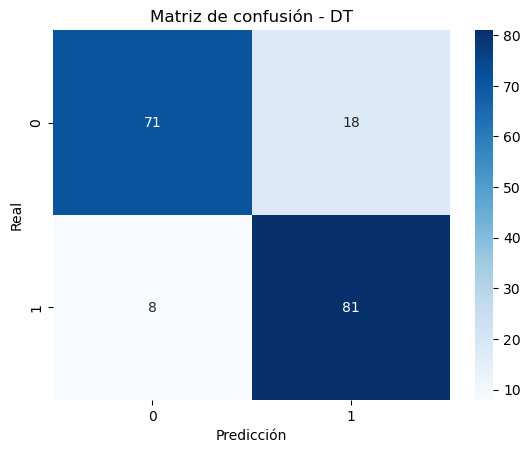



Resultados para el modelo DT:
  Accuracy: 0.8539325842696629
  Recall: 0.9101123595505618
  F1-score: 0.8617021276595744
  Precision: 0.8181818181818182
--------------------
Matriz de confusión:


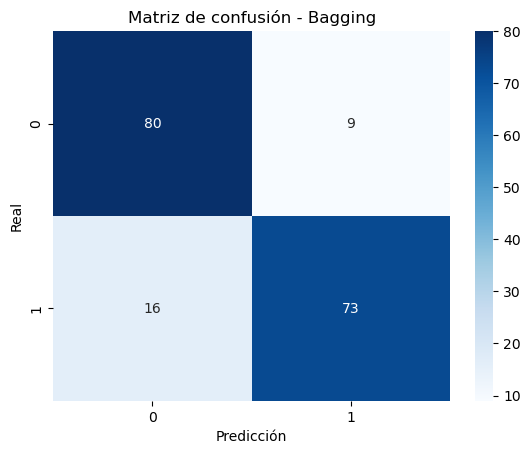



Resultados para el modelo Bagging:
  Accuracy: 0.8595505617977528
  Recall: 0.8202247191011236
  F1-score: 0.8538011695906432
  Precision: 0.8902439024390244
--------------------
Matriz de confusión:


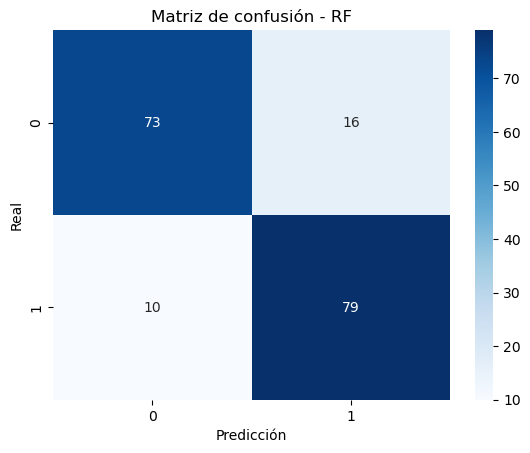



Resultados para el modelo RF:
  Accuracy: 0.8539325842696629
  Recall: 0.8876404494382022
  F1-score: 0.8586956521739131
  Precision: 0.8315789473684211
--------------------
Matriz de confusión:


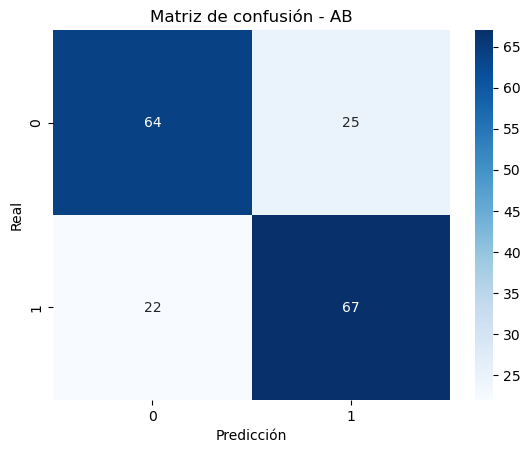



Resultados para el modelo AB:
  Accuracy: 0.7359550561797753
  Recall: 0.7528089887640449
  F1-score: 0.7403314917127072
  Precision: 0.7282608695652174
--------------------
Matriz de confusión:


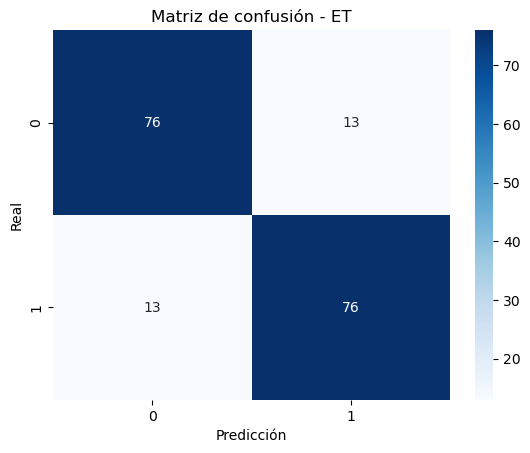



Resultados para el modelo ET:
  Accuracy: 0.8539325842696629
  Recall: 0.8539325842696629
  F1-score: 0.8539325842696629
  Precision: 0.8539325842696629
--------------------
Matriz de confusión:


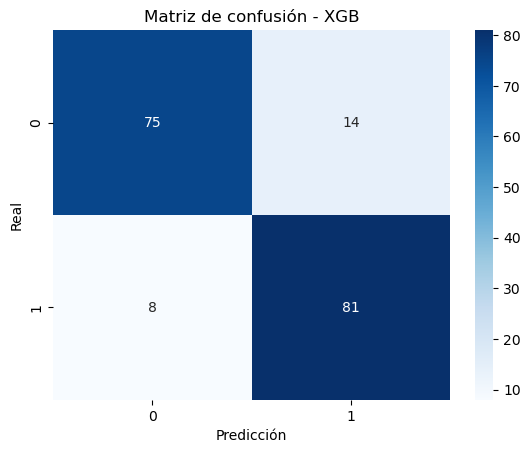



Resultados para el modelo XGB:
  Accuracy: 0.8764044943820225
  Recall: 0.9101123595505618
  F1-score: 0.8804347826086957
  Precision: 0.8526315789473684
--------------------
Matriz de confusión:


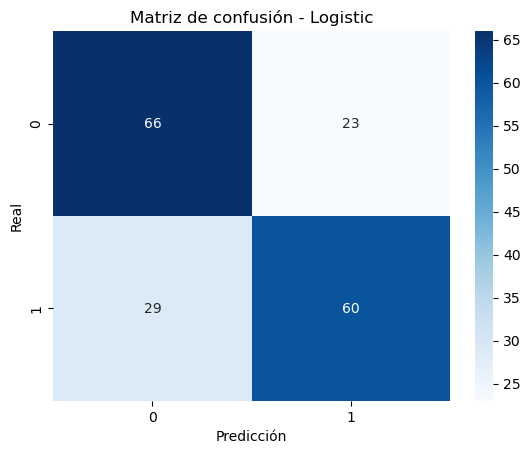



Resultados para el modelo Logistic:
  Accuracy: 0.7078651685393258
  Recall: 0.6741573033707865
  F1-score: 0.6976744186046512
  Precision: 0.7228915662650602
--------------------
Matriz de confusión:


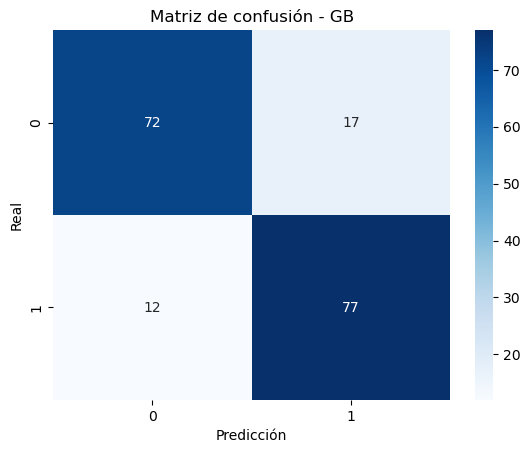



Resultados para el modelo GB:
  Accuracy: 0.8370786516853933
  Recall: 0.8651685393258427
  F1-score: 0.8415300546448088
  Precision: 0.8191489361702128
--------------------
          accuracy   f1  precision  recall
models                                    
AB            0.74 0.74       0.73    0.75
Bagging       0.86 0.85       0.89    0.82
DT            0.85 0.86       0.82    0.91
ET            0.85 0.85       0.85    0.85
GB            0.84 0.84       0.82    0.87
Logistic      0.71 0.70       0.72    0.67
RF            0.85 0.86       0.83    0.89
XGB           0.88 0.88       0.85    0.91


C:\Users\THINKBOOK\AppData\Local\Temp\ipykernel_11788\3918803410.py:43: FutureWarning: The provided callable <function mean at 0x000001F35CC349A0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot = pd.pivot_table(df_results, values = ['accuracy', 'recall', 'f1', 'precision'],


In [38]:
#Lista para guardar resultados
results = []

for model_name, prediction in zip(models, predictions):
    #Matriz de confusion
    cm = confusion_matrix(y_test, prediction)
    print("Matriz de confusión:")
    
    #Representar la matriz de confusion en un diagrama de calor
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()
    print("\n")

    #Metricas para evaluar modelos
    accuracy = accuracy_score(y_test, prediction)
    recall = recall_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    precision = precision_score(y_test, prediction)

    print(f"Resultados para el modelo {model_name}:")
    print(f"  Accuracy: {accuracy}")
    print(f"  Recall: {recall}")
    print(f"  F1-score: {f1}")
    print(f"  Precision: {precision}")
    print("-" * 20)

    #Guardar resultados en una lista de diccionarios
    results.append({
        'models': model_name,
        'accuracy': accuracy,
        'recall': recall,
        'f1': f1,
        'precision': precision
    })

#Crear Dataframe con todos los resultados
df_results = pd.DataFrame(results)

#Crear tabla pivot
pivot = pd.pivot_table(df_results, values = ['accuracy', 'recall', 'f1', 'precision'],
                       index='models', 
                       aggfunc=np.mean) 

pivot = np.round(pivot,2)
print(pivot)

*Tabla resumen de métricas de evaluación*

In [39]:
pivot.sort_values(by=['accuracy'], ascending = False)

,accuracy,f1,precision,recall
models,,,,
XGB,0.88,0.88,0.85,0.91
Bagging,0.86,0.85,0.89,0.82
DT,0.85,0.86,0.82,0.91
ET,0.85,0.85,0.85,0.85
RF,0.85,0.86,0.83,0.89
GB,0.84,0.84,0.82,0.87
AB,0.74,0.74,0.73,0.75
Logistic,0.71,0.70,0.72,0.67


En este caso, el modelo que presenta el mejor desempeño en las métricas de *accuracy, precision y recall* es **XGBoost**. La métrica de *accuracy* resulta informativa, ya que las clases en el dataset están balanceadas. No obstante, dado que el problema está relacionado con el diagnóstico de enfermedades, es fundamental priorizar métricas como *precision y recall*.

La *precision* es especialmente relevante porque, en el ámbito de la salud, el costo de un **falso positivo** es alto: predecir erróneamente que una persona sana tiene diabetes puede generar preocupación innecesaria, gastos adicionales en exámenes clínicos y un impacto emocional considerable. Por ello, privilegiar la precisión contribuye a minimizar este riesgo.

Por otro lado, el *recall* también es crítico, ya que necesitamos que el modelo sea capaz de detectar la mayor cantidad posible de casos positivos reales. Un bajo recall implicaría pasar por alto a pacientes que sí presentan la enfermedad, lo cual tendría consecuencias aún más graves en términos de diagnóstico y tratamiento oportuno.

En síntesis, aunque la *accuracy* confirma un buen desempeño general, la elección de XGBoost se justifica principalmente porque ofrece un equilibrio adecuado entre precision y recall, lo que lo convierte en el modelo más apropiado para este caso. 

#### 6. Mostrar las features más relevantes (Feature Importance)
Para este caso resulta útil evidenciar cuáles son las cacrateristicas más importantes, aquellas que tienen un mayor peso e influencia para la determinación de la diabetes. 

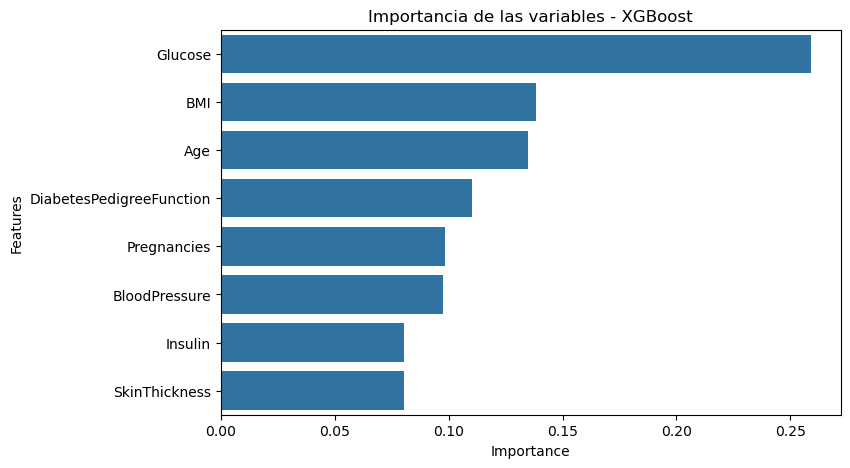

In [51]:
import pandas as pd
import seaborn as sns

X_resampled = df.drop("Outcome", axis=1)

importances = model_XGB.feature_importances_
feat_imp = pd.Series(importances, index=X_resampled.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Importancia de las variables - XGBoost")
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

La gráfica de *Feature Importance* permite identificar las variables con mayor influencia en la predicción de la diabetes. En este caso, se observa que la **glucosa** y el **índice de masa corporal (BMI)** son determinantes, lo cual está respaldado por la literatura científica. La glucosa constituye uno de los indicadores más directos de la diabetes, ya que el diagnóstico se basa principalmente en la detección de niveles anormales en sangre (por ejemplo: glucosa en ayunas ≥ 126 mg/dl). Por su parte, el BMI es un indicador relevante del grado de obesidad, y el sobrepeso representa un factor de riesgo significativo para el desarrollo de diabetes tipo 2. Un BMI elevado incrementa la resistencia a la insulina, dificultando que el organismo regule adecuadamente los niveles de glucosa.

## Conclusiones 

Para el presente problema de clasificación se concluye que se logró identificar, con un alto nivel de confiabilidad, el modelo más adecuado para realizar predicciones correctas. El algoritmo que mostró el mejor desempeño en las métricas de *accuracy, precision y recall* fue **XGBoost**. Dado que el caso está asociado al diagnóstico de enfermedades, resulta fundamental priorizar las métricas de precision y recall por encima de métricas globales como accuracy.

En particular, se otorgó mayor relevancia a la precision, ya que un falso positivo (predecir erróneamente que una persona sana tiene diabetes) puede generar consecuencias negativas como ansiedad innecesaria, costos adicionales en exámenes clínicos y complicaciones en la gestión de la salud. De igual forma, se consideró esencial la métrica de recall, pues el modelo debe ser capaz de detectar la mayor cantidad posible de casos positivos reales, evitando que pacientes con la enfermedad pasen desapercibidos.

Asimismo, la gráfica de *Feature Importances* evidencia que el modelo no solo presenta un buen desempeño predictivo, sino que además coincide con hallazgos respaldados por la literatura médica. Variables como la **glucosa** y el **índice de masa corporal (BMI)** se identifican como factores críticos, lo cual otorga validez externa al modelo: no solo aprende de los datos, sino que está alineado con el conocimiento clínico existente.

Finalmente, respecto al dataset original, se detectaron inconsistencias y valores extremadamente atípicos, algunos prácticamente imposibles de ocurrencia. Por ello, se recomienda que en futuros estudios se recopilen datos más consistentes y representativos de la población promedio, con el objetivo de mejorar la calidad de las predicciones y la aplicabilidad del modelo en contextos reales.